# Training a TensorFlow model to classify Entailment and Contradiction in writing

import dependencies

In [1]:
%%capture
!pip install kaggle
!pip install transformers
!pip install sentencepiece
!pip install livelossplot
import livelossplot
import transformers 
import gc
from sklearn.model_selection import StratifiedShuffleSplit
import tensorflow as tf
import numpy as np
import collections
import pandas as pd
import tensorflow.keras as keras
import tqdm.notebook as tqdm
import copy
import math
import random

In [2]:
#!mkdir /root/.kaggle/
#!cp -f ./kaggle.json /root/.kaggle/kaggle.json
#!chmod 600 /root/.kaggle/kaggle.json

In [3]:
#!kaggle competitions download -c contradictory-my-dear-watson

In [4]:
#!unzip test.csv.zip
#!rm -f test.csv.zip
#!unzip train.csv.zip
#!rm -f train.csv.zip

# Load in the Dataset

In [5]:
# HYPER PARAMETERS 
TEST_BATCH_SIZE =16

TRAIN_BATCH_SIZE = 16
LEARNING_RATE = 1e-5 # Larger learning rates instantly destroy pretrained weights.
NUM_TRAIN = 'All'

In [6]:
train_pd = pd.read_csv("./train.csv")
sample_submission_dp = pd.read_csv("./sample_submission.csv")
test_pd = pd.read_csv("./test.csv")
label_idx = {
    0: 'entailment',
    1: 'neutral',
    2: 'contradiction'
}

In [7]:
train_premise = [text for text in train_pd['premise']]
train_hypothesis = [text for text in train_pd['hypothesis']]
train_language = [text for text in train_pd['language']]
train_labels = [label for label in train_pd['label']]

In [8]:
test_premise = [text for text in test_pd['premise']]
test_hypothesis = [text for text in test_pd['hypothesis']]
test_language = [text for text in test_pd['language']]
test_ids = [id for id in test_pd['id']]

In [9]:
# Split into Train and Val Set
splitter = StratifiedShuffleSplit(n_splits = 2, test_size = 0.003, train_size = 0.997)
for train_idx, test_idx in splitter.split(train_premise, train_labels):
  break

In [10]:
train_tmp_premise = []
train_tmp_hypothesis = []
train_tmp_language = []
train_tmp_labels = []

val_tmp_premise = []
val_tmp_hypothesis = []
val_tmp_language = []
val_tmp_labels = []
for idx in train_idx:
  train_tmp_premise += [train_premise[idx]]
  train_tmp_hypothesis += [train_hypothesis[idx]]
  train_tmp_language += [train_language[idx]]
  train_tmp_labels += [train_labels[idx]]
for idx in test_idx:
  val_tmp_premise += [train_premise[idx]]
  val_tmp_hypothesis += [train_hypothesis[idx]]
  val_tmp_language += [train_language[idx]]
  val_tmp_labels += [train_labels[idx]]

In [11]:
train_premise = train_tmp_premise
train_hypothesis = train_tmp_hypothesis
train_language = train_tmp_language
train_labels = train_tmp_labels
# Val
val_premise = val_tmp_premise
val_hypothesis = val_tmp_hypothesis 
val_language = val_tmp_language
val_labels = val_tmp_labels

In [12]:
if NUM_TRAIN != "All":
  train_premise = train_premise[:NUM_TRAIN]
  train_hypothesis = train_hypothesis[: NUM_TRAIN]
  train_language = train_language[:NUM_TRAIN]
  train_labels = train_labels[:NUM_TRAIN]

In [13]:
class TrainDataset(keras.utils.Sequence):
  def __init__(self, phrase, hypothesis, labels, batch_size):
    assert len(phrase) == len(hypothesis) 
    self.phrase = phrase
    self.hypothesis = hypothesis
    self.labels = labels
    self.batch_size = batch_size
    self.cur_idx = 0
  def reset(self):
    self.cur_idx = 0
  def __len__(self):
    return len(self.phrase) // self.batch_size + 1 if len(self.phrase) % self.batch_size != 0 else len(self.phrase) // self.batch_size
  def __getitem__(self, idx):
    '''
    Extracts a batch out of the train dataset
    '''
    if self.cur_idx == self.__len__():
      phrase = self.phrase[self.cur_idx * self.batch_size:]
      hypothesis = self.hypothesis[self.cur_idx * self.batch_size:]
      labels = self.labels[self.cur_idx * self.batch_size:]
    else:
      phrase = self.phrase[self.cur_idx * self.batch_size: (self.cur_idx + 1) * self.batch_size]
      hypothesis = self.hypothesis[self.cur_idx * self.batch_size: (self.cur_idx + 1) * self.batch_size]
      labels = self.labels[self.cur_idx * self.batch_size: (self.cur_idx + 1) * self.batch_size]
    self.cur_idx += 1
    if self.cur_idx >= self.__len__():
      print("WARNING: ITERATING AGAIN")
      self.reset();
    return phrase, hypothesis, labels

In [14]:
class TestDataset(keras.utils.Sequence):
  def __init__(self, phrase, hypothesis, ids, batch_size):
    assert len(phrase) == len(hypothesis)
    self.phrase = phrase
    self.hypothesis = hypothesis
    self.ids = ids
    self.batch_size = batch_size 
    self.cur_idx = 0
  def reset(self):
    self.cur_idx = 0
  def __len__(self):
    return len(self.phrase) // self.batch_size + 1 if len(self.phrase) % self.batch_size != 0 else len(self.phrase) // self.batch_size
  def __getitem__(self, idx):
    if self.cur_idx == self.__len__():
      phrase = self.phrase[self.cur_idx * self.batch_size:]
      hypothesis = self.hypothesis[self.cur_idx * self.batch_size:]
      ids = self.ids[self.cur_idx * self.batch_size:]
    else:
      phrase = self.phrase[self.cur_idx * self.batch_size: (self.cur_idx + 1) * self.batch_size]
      hypothesis = self.hypothesis[self.cur_idx * self.batch_size: (self.cur_idx + 1) * self.batch_size]
      ids = self.ids[self.cur_idx * self.batch_size: (self.cur_idx + 1) * self.batch_size]
    self.cur_idx += 1
    if self.cur_idx >= self.__len__():
      print("WARNING: ITERATING AGAIN")
      self.reset();
    return phrase, hypothesis, ids

In [15]:
test_dataloader = TestDataset(test_premise, test_hypothesis, test_ids, TEST_BATCH_SIZE)
train_dataloader = TrainDataset(train_premise, train_hypothesis, train_labels, TRAIN_BATCH_SIZE)
val_dataloader = TrainDataset(val_premise, val_hypothesis, val_labels, TEST_BATCH_SIZE)

Full Model(QA Net + Phrase-Hypothesis Attention)

In [16]:
class QABlock(keras.layers.Layer):
  def __init__(self, in_features, regularization= 1e-3):
    super().__init__()
    self.regularization = regularization
    self.in_features = in_features
    self.conv = keras.layers.Conv1D(self.in_features, 7, padding = 'same', activation = 'relu', kernel_regularizer = tf.keras.regularizers.l2(self.regularization))
    self.layer_norm = keras.layers.LayerNormalization()
  def call(self, x):
    return self.conv(self.layer_norm(x)) + x

In [17]:
class MultiHeadAttention(keras.layers.Layer):
  '''
  Computes MultiHead Attention with a Residual connection built in.
  '''
  def __init__(self, in_features, inner_features, num_heads, regularization = 1e-3, drop_prob = 0.0):
    super().__init__()
    self.drop_prob = drop_prob
    self.regularization = regularization

    self.in_features = in_features
    self.inner_features = inner_features
    self.num_heads = num_heads
    
    self.K = keras.layers.Dense(self.inner_features * self.num_heads, kernel_regularizer = tf.keras.regularizers.l2(self.regularization))
    self.V = keras.layers.Dense(self.inner_features * self.num_heads, kernel_regularizer = tf.keras.regularizers.l2(self.regularization))
    self.Q = keras.layers.Dense(self.inner_features * self.num_heads, kernel_regularizer = tf.keras.regularizers.l2(self.regularization))
    
    self.Dropout = keras.layers.Dropout(self.drop_prob)
    self.Linear = keras.layers.Dense(self.in_features, kernel_regularizer = tf.keras.regularizers.l2(self.regularization))
    self.gamma = tf.Variable(0., trainable = True)
  def call(self, x):
    '''
    x: Tensor(B, L, C)
    '''
    B, L, _ = x.shape
    Keys = self.K(x)
    Values = self.V(x)
    Queries = self.Q(x) # (B, L, self.inner_features * self.num_heads)
    # Reshape Tensors
    Keys = tf.reshape(Keys, (B, L, self.num_heads, self.inner_features))
    Values = tf.reshape(Values, (B, L, self.num_heads, self.inner_features))
    Queries = tf.reshape(Queries, (B, L, self.num_heads, self.inner_features))
    
    Keys = tf.transpose(Keys, perm = (0, 2, 1, 3))
    Values = tf.transpose(Values, perm = (0, 2, 1, 3))
    Queries = tf.transpose(Queries, perm = (0, 2, 1, 3))

    Keys = tf.reshape(Keys, (B * self.num_heads, L, self.inner_features))
    Values = tf.reshape(Values, (B * self.num_heads, L, self.inner_features))
    Queries = tf.reshape(Queries, (B * self.num_heads, L, self.inner_features))

    # Att Dot Prod
    att_mat = tf.matmul(Keys, tf.transpose(Queries, perm = (0, 2, 1))) / math.sqrt(self.inner_features)
    att_scores = tf.keras.activations.softmax(att_mat) # (BH, L, L)

    vals = tf.matmul(att_scores, Values) # (BH, L, I)
    vals = tf.reshape(vals, (B, self.num_heads, L, self.inner_features))
    vals = tf.transpose(vals, perm = (0, 2, 1, 3))
    vals = tf.reshape(vals, (B, L, self.num_heads * self.inner_features))
    
    dropped_vals = self.Dropout(vals);
    processed = self.Linear(dropped_vals) # (B, L, C)
    return self.gamma * processed + x

In [18]:
class EncoderDecoderAttention(keras.layers.Layer):
  def __init__(self, in_dim, inner_dim, num_heads, regularization = 1e-3):
    # Encoder: Keys and Values
    # Decoder: Queries(Hypothesis)
    # No Dropout, as we don't want to lose features
    super().__init__()
    self.regularization = regularization
    self.in_dim = in_dim
    self.inner_dim = inner_dim
    self.num_heads = num_heads
    self.K = keras.layers.Dense(self.inner_dim * self.num_heads, kernel_regularizer = tf.keras.regularizers.l2(self.regularization))
    self.V = keras.layers.Dense(self.inner_dim * self.num_heads, kernel_regularizer = tf.keras.regularizers.l2(self.regularization))
    self.Q = keras.layers.Dense(self.inner_dim * self.num_heads, kernel_regularizer = tf.keras.regularizers.l2(self.regularization))

    self.Linear = keras.layers.Dense(self.in_dim, kernel_regularizer = tf.keras.regularizers.l2(self.regularization))
     
  def call(self, encoder, decoder):
    '''
    Encoder-Decoder Attention, Relating Together the phrases and hypotheses
    encoder: Tensor(B, L_enc, C)
    decoder: Tensor(B, L_dec, C)
    '''
    B, L_enc, _ = encoder.shape
    _, L_dec, _ = decoder.shape

    Keys = self.K(encoder)
    Values = self.V(encoder)
    Queries = self.Q(decoder) # (B, L_dec, HI)

    Keys = tf.reshape(Keys, (B, L_enc, self.num_heads, self.inner_dim))
    Values = tf.reshape(Values, (B, L_enc, self.num_heads, self.inner_dim))
    Queries = tf.reshape(Queries, (B, L_dec, self.num_heads, self.inner_dim))

    Keys = tf.transpose(Keys, perm = (0, 2, 1, 3))
    Values = tf.transpose(Values, perm = (0, 2, 1, 3))
    Queries = tf.transpose(Queries, perm = (0, 2, 1, 3))

    Keys = tf.reshape(Keys, (B * self.num_heads, L_enc, self.inner_dim))
    Values = tf.reshape(Values, (B * self.num_heads, L_enc, self.inner_dim))
    Queries = tf.reshape(Queries, (B * self.num_heads, L_dec, self.inner_dim))

    att_mat = tf.keras.activations.softmax(tf.matmul(Keys, tf.transpose(Queries, (0, 2, 1))) / math.sqrt(self.inner_dim)) # (B, L_enc, L_dec)
    att_scores = tf.matmul(tf.transpose(att_mat, perm = (0, 2, 1)), Values)
    
    att_scores = tf.reshape(att_scores, (B, self.num_heads, L_dec, self.inner_dim))
    att_scores = tf.transpose(att_scores, (0, 2, 1, 3))
    att_scores = tf.reshape(att_scores, (B, L_dec, self.num_heads * self.inner_dim))
    return self.Linear(att_scores)

In [19]:
class ContextQueryAttention(keras.layers.Layer):
  '''
  Computes Context-Query Attention between phrase and hypothesis
  '''
  def __init__(self, regularization = 1e-4):
    super().__init__()
    self.regularization = regularization
    self.similarity = keras.layers.Dense(1, kernel_regularizer = tf.keras.regularizers.l2(self.regularization))
  def call(self, context, query):
    '''
    Context: Tensor(B, L_C, C) 
    Query: Tensore(B, L_Q, C)
    '''
    B, L_C, C = context.shape
    _, L_Q, _ = query.shape
    vals = []
    for c in range(L_C):
      for q in range(L_Q):
        CONTEXT = context[:, c, :] # (B, C)
        QUERY = query[:, q, :] # (B, C)
        concat = tf.concat([CONTEXT, QUERY, CONTEXT * QUERY], axis = -1) # (B, 3C)
        vals += [concat]
    big_dot = tf.stack(vals, axis = 1)
    big_dot = tf.reshape(big_dot, (B, L_C, L_Q, 3 * C))
    # Construct big dot product matrix
    dot_producted = tf.keras.activations.softmax(tf.squeeze(self.similarity(big_dot)))
    # Dot Product with Query Matrix
    attended = tf.matmul(dot_producted, query)
    return attended    

In [20]:
class Encoder(keras.layers.Layer):
  def __init__(self, in_dim, inner_dim, num_heads, num_conv, regularization = 1e-3, drop_prob = 0.1):
    super().__init__()
    self.drop_prob = drop_prob
    self.regularization = regularization
    
    self.in_dim = in_dim 
    self.inner_dim = inner_dim
    self.num_heads = num_heads
    self.num_conv = num_conv
    if self.num_conv != 0:
      self.conv = keras.Sequential([
        QABlock(self.in_dim, regularization = self.regularization) for i in range(self.num_conv)
      ])
    self.MultiHeadAttention = MultiHeadAttention(self.in_dim, self.inner_dim, self.num_heads)
    self.MAHNorm = keras.layers.LayerNormalization()
    self.Linear = keras.layers.Dense(self.in_dim, kernel_regularizer = tf.keras.regularizers.l2(self.regularization), activation = 'relu')
    self.LinearNorm = keras.layers.LayerNormalization()
    self.Dropout = keras.layers.Dropout(self.drop_prob)
  def call(self, x):
    '''
    Tensor(B, C, L)
    '''
    pos_enc = self.positional_encodings(x)
    if self.num_conv != 0:
      pos_enc = self.conv(pos_enc)
    attended = self.MultiHeadAttention(self.MAHNorm(pos_enc)) + pos_enc
    attended = self.Dropout(attended)
    linear = self.Linear(self.LinearNorm(attended)) + attended
    return linear
  def positional_encodings(self, x):
    '''
    Adds positional encodings to the input
    x: Tensor(B, L, C)
    '''
    B, L, C = x.shape
    positional_encodings = np.zeros((L, C), dtype = np.float32)
    for pos in range(L):
      for i in range(0, C, 2):
        positional_encodings[pos, i] = math.sin(pos / 10000 ** (2 * i / self.inner_dim))
        positional_encodings[pos, i + 1] = math.cos(pos / 10000 ** (2 * (i + 1) / self.inner_dim))
    batched_pos = []
    for b in range(B):
      batched_pos += [copy.deepcopy(positional_encodings)] 
    batched_pos = np.stack(batched_pos, axis = 0)
    return batched_pos + x

In [21]:
class NoOverfitQT(keras.layers.Layer):
  def __init__(self):
    super().__init__()
    self.in_dim = 768
    self.tokenizer = transformers.AutoTokenizer.from_pretrained("xlm-roberta-base")
    self.embeddings = transformers.TFAutoModel.from_pretrained("jplu/tf-xlm-roberta-base")
    self.embeddings.config.dropout = 0.2
    self.embeddings.config.attention_dropout = 0.2
    self.trainable = True
    self.max_length = 120
  def call(self, phrases, hypothesis):
    sentences = []
    for idx in range(len(phrases)):
      phrase = phrases[idx]
      hypot = hypothesis[idx]
      sentences += [self.tokenizer.cls_token + phrase + self.tokenizer.sep_token + hypot ]
    sentences_encoded = self.tokenizer(sentences, add_special_tokens= False, max_length = self.max_length, padding = True, truncation = True, return_tensors = 'tf')
    encoded = self.embeddings(**sentences_encoded)
    return encoded[0]

In [22]:
class PHTransformerAlpha(keras.Model):
  def __init__(self, num_classes, drop_prob = 0.2, regularization = 1e-3):
    super().__init__()
    self.drop_prob = drop_prob
    self.regularization = regularization
    self.num_classes = num_classes
   

    self.embeddings = NoOverfitQT()
    self.Dropout = keras.layers.Dropout(self.drop_prob)
    
    self.dense = keras.Sequential([
      keras.layers.Dense(1024, kernel_regularizer = tf.keras.regularizers.l2(self.regularization), activation = 'relu'),
      keras.layers.Dense(1536, kernel_regularizer = tf.keras.regularizers.l2(self.regularization), activation = 'relu'),
      keras.layers.Dense(768, kernel_regularizer = tf.keras.regularizers.l2(self.regularization), activation = 'relu'),
      keras.layers.Dense(self.num_classes, kernel_regularizer = tf.keras.regularizers.l2(self.regularization))])
  def features(self, phrase, hypothesis):
    return self.embeddings(phrase, hypothesis)
  def call(self, phrase, hypothesis):
    encoded = self.embeddings(phrase, hypothesis)
    encoded = self.Dropout(encoded)
    #encoded = self.MHA(encoded)
    mean_pooled = tf.reduce_mean(encoded, 1)
    mean_pooled = self.Dropout(mean_pooled) 
    return self.dense(mean_pooled) 


In [23]:
class Stage2QT(keras.Model):
  def __init__(self, num_classes, model_path, drop_prob = 0.2, regularization = 1e-4):
    super().__init__()
    self.regularization = regularization 
    self.drop_prob = drop_prob
    self.num_classes = num_classes
    self.model_path = model_path
    self.stage1 = PHTransformerAlpha(self.num_classes)
    self.stage1.trainable = False # Freeze Weight 
     # HYPERPARAMETERS
    self.num_final_enc = 2
    self.in_dim = 768
    self.inner_dim = 256
    self.num_att_heads = 4
    self.num_conv = 0
    self.MHA = keras.Sequential([
      Encoder(self.in_dim, self.inner_dim, self.num_att_heads, self.num_conv) for i in range(self.num_final_enc)
    ])

    self.Dropout = keras.layers.Dropout(self.drop_prob)
    self.Dense = self.stage1.dense
    self.Dense.trainable = True
  def call(self, phrase, hypotheses):
    embeddings = self.stage1.features(phrase, hypotheses) # (B, L, C)
    encoded = self.MHA(embeddings)
    reduced = tf.reduce_mean(encoded, 1)
    reduced = self.Dropout(reduced)
    return self.Dense(reduced)


# Train the Model

In [24]:
model = PHTransformerAlpha(3)

In [27]:
model.load_weights("./bestAccStage1.2/model")

In [25]:
def training_fn(model, NUM_EPOCHS, NUM_STEPS, best_loss_path, best_acc_path):
  optimizer = transformers.AdamWeightDecay(learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(LEARNING_RATE, NUM_STEPS, 0.95), weight_decay_rate = 4e-3)
  liveloss = livelossplot.PlotLosses()
  best_val_loss = 999
  best_val_acc = 0.0
  for EPOCH in range(NUM_EPOCHS):
    logs = {}
    logs['loss'] = 0
    for STEP in tqdm.tqdm(range(NUM_STEPS)):
      for phrases, hypotheses, labels in train_dataloader:
        assert len(phrases) != 0
        labels = np.array(labels)
        with tf.GradientTape() as tape:
          logits = model(phrases, hypotheses, training = True)
          softmaxed_logits = tf.keras.activations.softmax(logits)
          loss = tf.reduce_sum(tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits = True)) 
          
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        logs['loss'] += loss.numpy().item() / NUM_STEPS / len(phrases)
        del phrases
        del hypotheses
        del labels
        del logits
        del softmaxed_logits
        gc.collect() 
        break
    # Evaluate Model on validation set
    
    logs['val_loss'] = 0
    logs['accuracy'] = 0
    count = 0
    for phrases, hypotheses, labels in val_dataloader:
      labels = np.array(labels)
      logits = model(phrases, hypotheses, training = False); # (b, 3)
      logs['val_loss'] += tf.reduce_sum(tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits = True)).numpy().item() / logits.shape[0] 
      vals = tf.keras.activations.softmax(logits);
      argmax = tf.argmax(vals, axis = -1).numpy() # (B)
      logs['accuracy'] += np.sum((argmax == labels).astype(np.int32)).item() / argmax.shape[0]
      count += 1
    logs['val_loss'] /= count;
    logs['accuracy'] /= count;
    if logs['val_loss'] <= best_val_loss:
      best_val_loss = logs['val_loss']
      model.save_weights(best_loss_path)
    if logs['accuracy'] >= best_val_acc:
      best_val_acc = logs['accuracy']
      model.save_weights(best_acc_path)
    liveloss.update(logs);
    liveloss.send();  

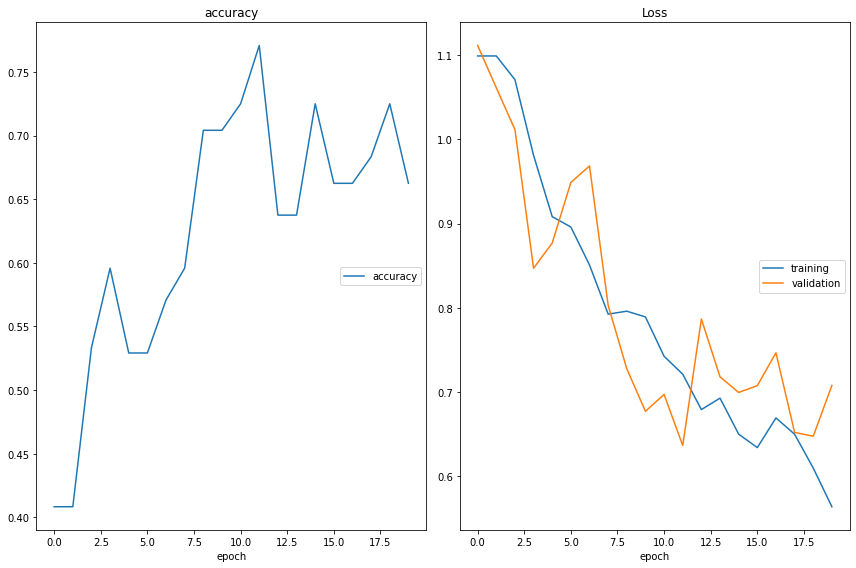

accuracy
	accuracy         	 (min:    0.408, max:    0.771, cur:    0.662)
Loss
	training         	 (min:    0.564, max:    1.099, cur:    0.564)
	validation       	 (min:    0.637, max:    1.112, cur:    0.708)


KeyboardInterrupt: ignored

In [26]:
with tf.device("GPU:0 "):
  training_fn(model, 50, 100, './bestValStage1.2/model', "./bestAccStage1.2/model");

In [ ]:
stage2 = Stage2QT(3, "./bestLoss")

In [ ]:
with tf.device("GPU: 0"):
  training_fn(stage2, 50, 100, './bestValStage2/model', './bestAccStage2/model')

Inference: Predict the CSV.

In [30]:
def inference(model, test_dataloader):
  predictions = {"id": [], 'prediction': []}
  for phrases, hypotheses, ids in tqdm.tqdm(test_dataloader):
    logits = tf.keras.activations.softmax(model(phrases, hypotheses, training = False)) # (B, 3)
    selected_logits = tf.math.argmax(logits, 1).numpy() # (B,)
    B = logits.shape[0]
    for b in range(B):
      prediction = selected_logits[b].item()
      id = ids[b]
      predictions['id'] += [id]
      predictions['prediction'] += [prediction]
    del logits
    del selected_logits
    del phrases
    del hypotheses
    del ids
  return predictions

In [31]:
predictions = inference(model, test_dataloader)

Create Dataframe and Submit.

In [32]:
df = pd.DataFrame(predictions)
df.set_index('id')

,prediction
id,
6aed8d36c4,0
25208d6ba0,0
e2e9ac7c0e,1
ba081d77e9,2
736398e1c2,1
...,...
d41b559e9f,1
40a9b0f08e,1
d8f3da717a,2


In [33]:
df.to_csv("./submission.csv", index = False)